In [1]:
import tensorflow as tf
from skimage import io
import sys
sys.path.append('create_models')
import create_models as cm
import os
import time
import numpy as np

## Set the which GPU to run
os.environ["CUDA_VISIBLE_DEVICES"] = '0'  

## trained model folder
model_folder = './trained_models/'

## Load testing images
image_dir = './images/CHO'								# image directory: save each input image as a RGB image [HxWx3], where each channel 
													# contain the same phase contrast image; normalize the values into pixel values of range: [0,255], dtype: np.uint8
img_fns = os.listdir(image_dir)
images = np.stack([io.imread(image_dir+'/{}'.format(img_fn)) for img_fn in img_fns])

Models: using `tf.keras` framework.


In [2]:
## Image preprocessing
print('Preprocessing ...')
backbone = 'efficientnetb7'  # EfficientNet-B7 for CHO cell data
preprocess_input = cm.get_preprocessing(backbone) 	## preprocessing function
images = preprocess_input(images); 					# will scale pixels between 0 and 1 and then will normalize each channel with respect to the ImageNet dataset
print('Preprocessing done !')

Preprocessing ...
<module 'tensorflow.python.keras.api._v1.keras.backend' from '/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/api/_v1/keras/backend/__init__.py'>
<module 'tensorflow.python.keras.api._v1.keras.layers' from '/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/api/_v1/keras/layers/__init__.py'>
<module 'tensorflow.python.keras.api._v1.keras.models' from '/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/api/_v1/keras/models/__init__.py'>
<module 'tensorflow.python.keras.api._v1.keras.utils' from '/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/api/_v1/keras/utils/__init__.py'>
Preprocessing done !


In [3]:
import matplotlib.pyplot as plt
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    SMALL_SIZE = 24
    MEDIUM_SIZE = 24
    BIGGER_SIZE = 24

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    return ax

In [4]:
## Load the trained model
model=tf.keras.models.load_model(model_folder+'/CHO-b7.h5')

W0327 05:22:15.678903 140532874311488 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0327 05:22:15.679864 140532874311488 deprecation.py:573] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/deprecation.py:507: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with distribution=normal is deprecated and will be removed in a future version.
Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
W0327 05:22:15.680438 140532874311488 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated an

In [5]:
## Label map prediction
start_time = time.time()
pr_masks = model.predict(images, batch_size=1); 	## probability maps [N(num of images) x H x W x C(class)] for 0: live, 1: intermediate, 2: dead, 3: background
pr_maps = np.argmax(pr_masks,axis=-1)   			# predicted label map
end_time = time.time()
print('Average time: {:.4f} per image'.format((end_time-start_time)/len(images)))

Average time: 0.1481 per image


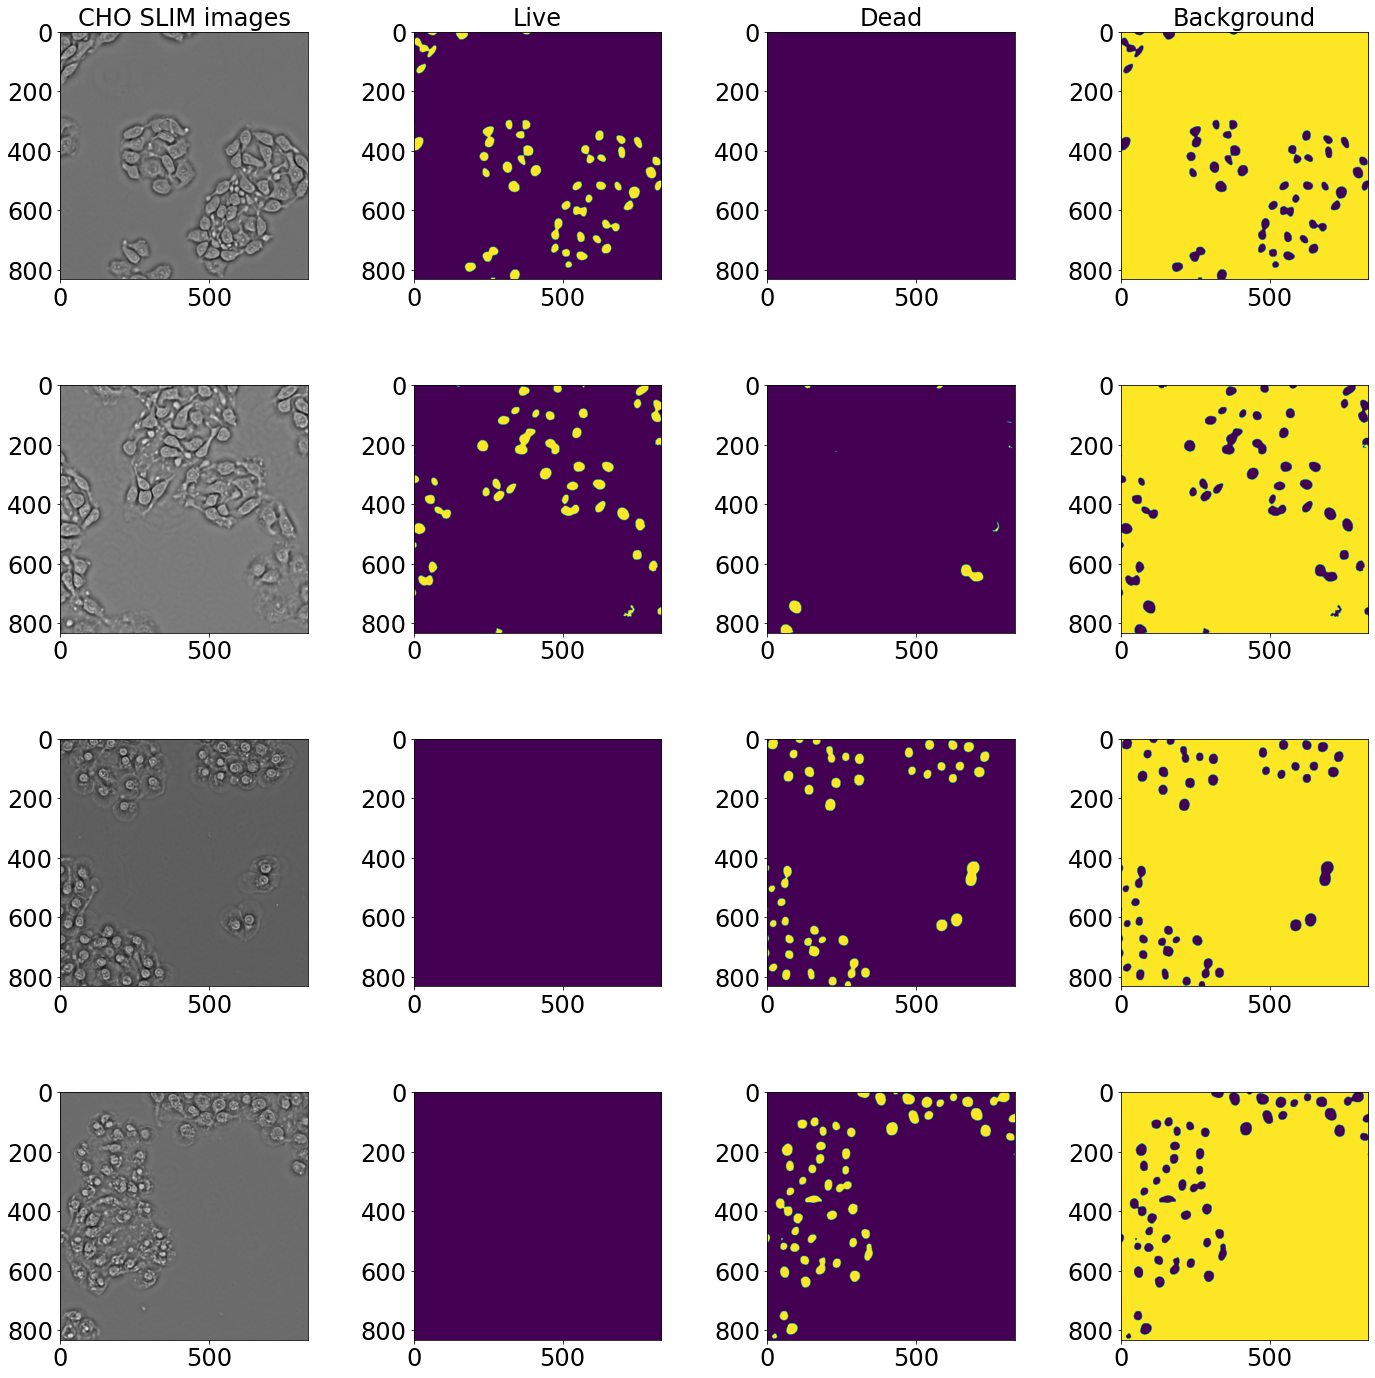

In [13]:
import random
indices = [12, 33, 49, 97] # 4 testing examples
ax = get_ax(len(indices),4,5)
for i, index in enumerate(indices):
    pr_map = pr_maps[index,:,:]
    ax[i, 0].imshow(io.imread(image_dir+'/{}'.format(img_fns[index])))
    ax[i, 1].imshow(pr_map == 0) # live
    ax[i, 2].imshow(pr_map == 1)  # dead
    ax[i, 3].imshow(pr_map ==2)   # background
    if i == 0:
        ax[i, 0].set_title('CHO SLIM images')
        ax[i, 1].set_title('Live')
        ax[i, 2].set_title('Dead')
        ax[i, 3].set_title('Background')